In [28]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve

In [29]:
data_file = os.path.join(os.getcwd(), "data", "wireless_hotspots.geojson")
geometric_df = gpd.read_file(data_file)

In [30]:
geometric_df

,Name,Description,geometry
0,kml_1,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.74751 1.35019 0.00000)
1,kml_2,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.83609 1.42804 0.00000)
2,kml_3,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.85298 1.30020 0.00000)
3,kml_4,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.84648 1.28633 0.00000)
4,kml_5,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.88965 1.39923 0.00000)
...,...,...,...
1795,kml_1796,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.85406 1.32343 0.00000)
1796,kml_1797,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.87082 1.33919 0.00000)
1797,kml_1798,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.83500 1.42953 0.00000)
1798,kml_1799,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.73158 1.34531 0.00000)


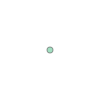

In [31]:
# Access geometry of the first feature
first_geometry = geometric_df.geometry.iloc[0]
first_geometry

In [32]:
# Function to extract data from HTML
def extract_attributes(html_data):
    soup = BeautifulSoup(html_data, 'html.parser')
    table_rows = soup.find_all('tr')
    
    attributes = {}
    for row in table_rows:
        th = row.find('th')
        td = row.find('td')
        if th and td:
            attributes[th.text.strip()] = td.text.strip()
    
    return pd.Series(attributes)

# Apply function to each row in the Description column
expanded_df = geometric_df['Description'].apply(lambda x: extract_attributes(x))

# Combine original DataFrame with expanded DataFrame, dropping Description column
combined_df = pd.concat([geometric_df.drop(columns=['Description']), expanded_df], axis=1)

In [33]:
combined_df

,Name,geometry,Y,X,LOCATION_NAME,LOCATION_TYPE,POSTAL_CODE,STREET_ADDRESS,OPERATOR_NAME,INC_CRC,FMEL_UPD_D
0,kml_1,POINT Z (103.74751 1.35019 0.00000),36922.92412,18450.95232,Bukit Batok CC,Community,659959,21 Bukit Batok Central,M1,9BB55356462956EF,20200318162531
1,kml_2,POINT Z (103.83609 1.42804 0.00000),45530.46595,28308.65184,1 Northpoint Drive,Community,768019,1 Northpoint Drive,M1,BD725D1716D3959C,20200318162531
2,kml_3,POINT Z (103.85298 1.30020 0.00000),31394.65632,30187.62071,155 Waterloo St,Government,187962,155 Waterloo Street,M1,05EF8371C69FD210,20200318162531
3,kml_4,POINT Z (103.84648 1.28633 0.00000),29861.29437,29464.67939,20 Upper Pickering St,Community,058284,20 Upper Pickering Street,M1,AD6A8E558E96E20B,20200318162531
4,kml_5,POINT Z (103.88965 1.39923 0.00000),42345.17715,34269.36498,7 Star Canteen,F&B,540338,338 Anchorvale Crescent,M1,67FF233DF9721356,20200318162531
...,...,...,...,...,...,...,...,...,...,...,...
1795,kml_1796,POINT Z (103.85406 1.32343 0.00000),33949.27857,30324.03757,Whampoa Market,F&B,320091,91 Whampoa Drive,Singtel,5ABEA91AE0240493,20200318162531
1796,kml_1797,POINT Z (103.87082 1.33919 0.00000),35706.37936,32173.31857,Woodleigh - NEL,Public Transport,347695,400 Upper Serangoon Road,Singtel,709A63EAB51A2DD1,20200318162531
1797,kml_1798,POINT Z (103.83500 1.42953 0.00000),45686.07005,28187.67873,Yishun MRT - NSL,Public Transport,769093,301 Yishun Avenue 2,Singtel,C359A402C8C11DEF,20200318162531
1798,kml_1799,POINT Z (103.73158 1.34531 0.00000),36394.85093,16691.34633,Yuhua Place,F&B,600347,347 Jurong East Avenue 1,Singtel,5A5C07968C24A925,20200318162531


In [34]:
combined_df.columns

Index(['Name', 'geometry', 'Y', 'X', 'LOCATION_NAME', 'LOCATION_TYPE',
       'POSTAL_CODE', 'STREET_ADDRESS', 'OPERATOR_NAME', 'INC_CRC',
       'FMEL_UPD_D'],
      dtype='object')

In [35]:
# Directory to save figures
save_dir = "figures"
os.makedirs(save_dir, exist_ok=True)

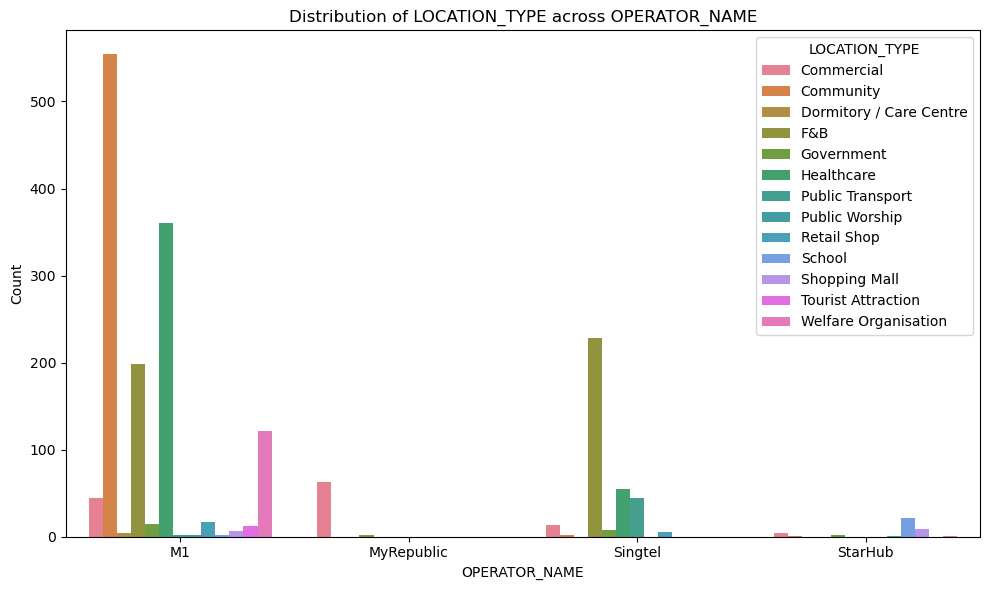

In [38]:
# Count frequencies of LOCATION_TYPE for each OPERATOR_NAME
count_data = combined_df.groupby(['OPERATOR_NAME', 'LOCATION_TYPE']).size().reset_index(name='count')

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='OPERATOR_NAME', y='count', hue='LOCATION_TYPE', data=count_data)
plt.title('Distribution of LOCATION_TYPE across OPERATOR_NAME')
plt.xlabel('OPERATOR_NAME')
plt.ylabel('Count')
plt.legend(title='LOCATION_TYPE')
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "Distribution of LOCATION_TYPE across OPERATOR_NAME.png"))
plt.show()

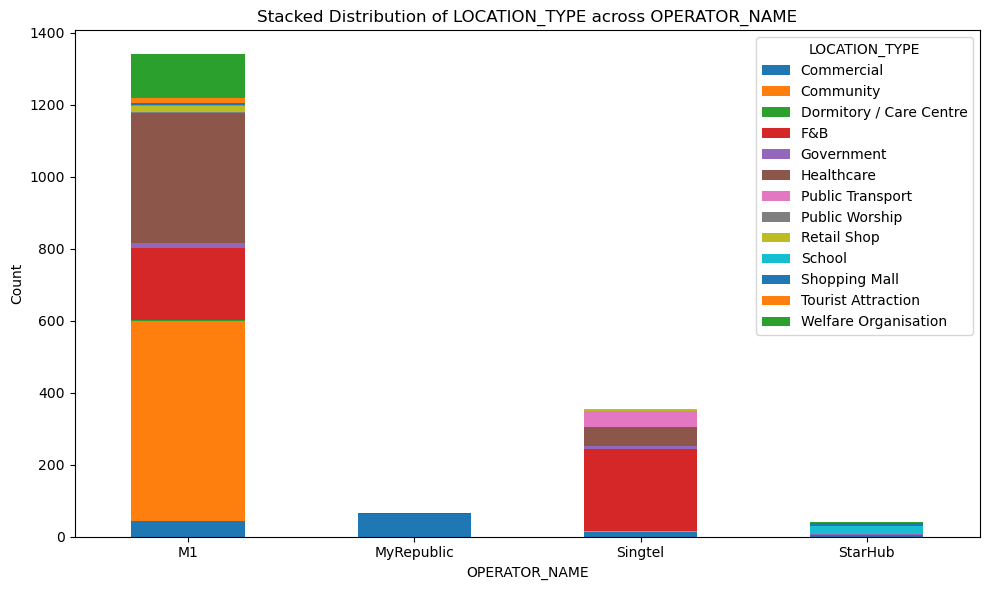

In [40]:
# Pivot the data for stacked bar chart
pivot_data = combined_df.pivot_table(index='OPERATOR_NAME', columns='LOCATION_TYPE', aggfunc='size', fill_value=0)

# Plotting
pivot_data.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Stacked Distribution of LOCATION_TYPE across OPERATOR_NAME')
# plt.xlabel('OPERATOR_NAME')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='LOCATION_TYPE')
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "Stacked Distribution of LOCATION_TYPE across OPERATOR_NAME.png"))
plt.show()

In [10]:
df = combined_df[["X", "Y", "OPERATOR_NAME", "LOCATION_TYPE"]]
df

,X,Y,OPERATOR_NAME,LOCATION_TYPE
0,18450.95232,36922.92412,M1,Community
1,28308.65184,45530.46595,M1,Community
2,30187.62071,31394.65632,M1,Government
3,29464.67939,29861.29437,M1,Community
4,34269.36498,42345.17715,M1,F&B
...,...,...,...,...
1795,30324.03757,33949.27857,Singtel,F&B
1796,32173.31857,35706.37936,Singtel,Public Transport
1797,28187.67873,45686.07005,Singtel,Public Transport
1798,16691.34633,36394.85093,Singtel,F&B


In [11]:
df["LOCATION_TYPE"].value_counts().sort_values(ascending=False)

LOCATION_TYPE
Community                  557
F&B                        428
Healthcare                 415
Commercial                 125
Welfare Organisation       123
Public Transport            46
Government                  25
School                      24
Retail Shop                 23
Shopping Mall               16
Tourist Attraction          12
Dormitory / Care Centre      4
Public Worship               2
Name: count, dtype: int64

In [12]:
# Determine the rarest 3 categories
rarest_categories = df['LOCATION_TYPE'].value_counts().index[-3:].tolist()

# Group the rarest 3 categories into a single category ('RareCategory')
df['LOCATION_TYPE_grouped'] = df['LOCATION_TYPE'].apply(lambda x: 'RareCategory' if x in rarest_categories else x)

# Label encoding for response variable
label_encoder = LabelEncoder()
df['LOCATION_TYPE_encoded'] = label_encoder.fit_transform(df['LOCATION_TYPE_grouped'])

# Drop columns which are no longer needed
df.drop(columns=["LOCATION_TYPE", "LOCATION_TYPE_grouped"], inplace=True)
df.rename(columns={"LOCATION_TYPE_encoded": "LOCATION_TYPE"}, inplace=True)
df

/var/folders/3f/xhw3kd5d62v0s4_2fvl3_7480000gn/T/ipykernel_32645/3855451717.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['LOCATION_TYPE_grouped'] = df['LOCATION_TYPE'].apply(lambda x: 'RareCategory' if x in rarest_categories else x)
/var/folders/3f/xhw3kd5d62v0s4_2fvl3_7480000gn/T/ipykernel_32645/3855451717.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['LOCATION_TYPE_encoded'] = label_encoder.fit_transform(df['LOCATION_TYPE_grouped'])
/var/folders/3f/xhw3kd5d62v0s4_2fvl3_7480000gn/T/ipyke

,X,Y,OPERATOR_NAME,LOCATION_TYPE
0,18450.95232,36922.92412,M1,1
1,28308.65184,45530.46595,M1,1
2,30187.62071,31394.65632,M1,3
3,29464.67939,29861.29437,M1,1
4,34269.36498,42345.17715,M1,2
...,...,...,...,...
1795,30324.03757,33949.27857,Singtel,2
1796,32173.31857,35706.37936,Singtel,5
1797,28187.67873,45686.07005,Singtel,5
1798,16691.34633,36394.85093,Singtel,2


In [13]:
df["OPERATOR_NAME"].value_counts()

OPERATOR_NAME
M1            1340
Singtel        355
MyRepublic      65
StarHub         40
Name: count, dtype: int64

In [14]:
# One-hot encoding
one_hot_encoder = OneHotEncoder(sparse_output=False)
encoded_features = one_hot_encoder.fit_transform(df[['OPERATOR_NAME']])

# Create DataFrame with encoded features
encoded_df = pd.DataFrame(encoded_features, columns=one_hot_encoder.get_feature_names_out(['OPERATOR_NAME']))

# Concatenate with the original DataFrame
df = pd.concat([df, encoded_df], axis=1)

# Drop "OPERATIR_NAME" and the last column which gives repetitive information
df.drop(columns=['OPERATOR_NAME'], inplace=True)
df = df.iloc[:, :-1]

In [15]:
df

,X,Y,LOCATION_TYPE,OPERATOR_NAME_M1,OPERATOR_NAME_MyRepublic,OPERATOR_NAME_Singtel
0,18450.95232,36922.92412,1,1.0,0.0,0.0
1,28308.65184,45530.46595,1,1.0,0.0,0.0
2,30187.62071,31394.65632,3,1.0,0.0,0.0
3,29464.67939,29861.29437,1,1.0,0.0,0.0
4,34269.36498,42345.17715,2,1.0,0.0,0.0
...,...,...,...,...,...,...
1795,30324.03757,33949.27857,2,0.0,0.0,1.0
1796,32173.31857,35706.37936,5,0.0,0.0,1.0
1797,28187.67873,45686.07005,5,0.0,0.0,1.0
1798,16691.34633,36394.85093,2,0.0,0.0,1.0


In [16]:
df["LOCATION_TYPE"].value_counts()

LOCATION_TYPE
1     557
2     428
4     415
0     125
10    123
5      46
3      25
8      24
7      23
6      18
9      16
Name: count, dtype: int64

In [17]:
# Split the data: last 200 rows for testing, the rest for training
train_df = df.iloc[:-200, :]
test_df = df.iloc[-200:, :]

# Separate features and target
X_train = train_df.loc[:, train_df.columns != 'LOCATION_TYPE']
y_train = train_df['LOCATION_TYPE']

X_test = test_df.loc[:, test_df.columns != 'LOCATION_TYPE']
y_test = test_df['LOCATION_TYPE']

In [18]:
train_columns = X_train.columns
train_columns

Index(['X', 'Y', 'OPERATOR_NAME_M1', 'OPERATOR_NAME_MyRepublic',
       'OPERATOR_NAME_Singtel'],
      dtype='object')

In [19]:
df

,X,Y,LOCATION_TYPE,OPERATOR_NAME_M1,OPERATOR_NAME_MyRepublic,OPERATOR_NAME_Singtel
0,18450.95232,36922.92412,1,1.0,0.0,0.0
1,28308.65184,45530.46595,1,1.0,0.0,0.0
2,30187.62071,31394.65632,3,1.0,0.0,0.0
3,29464.67939,29861.29437,1,1.0,0.0,0.0
4,34269.36498,42345.17715,2,1.0,0.0,0.0
...,...,...,...,...,...,...
1795,30324.03757,33949.27857,2,0.0,0.0,1.0
1796,32173.31857,35706.37936,5,0.0,0.0,1.0
1797,28187.67873,45686.07005,5,0.0,0.0,1.0
1798,16691.34633,36394.85093,2,0.0,0.0,1.0


In [20]:
# Scaling of dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
random_forest = RandomForestClassifier(random_state=42)

# Create hyperparameter grid for GridSearchCV
random_forest_grid = {"n_estimators": np.arange(70, 100, 5),
                      "max_depth": [10, 25, 30],
                      "min_samples_split": np.arange(2, 10, 2),
                      "min_samples_leaf": np.arange(1, 7, 2)}


# Set grid hyperparameter search for Random Forest
random_forest_model = GridSearchCV(random_forest, random_forest_grid, cv=5) 

# Fit grid hyperparameter search model on training data
random_forest_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [10, 25, 30],
                         'min_samples_leaf': array([1, 3, 5]),
                         'min_samples_split': array([2, 4, 6, 8]),
                         'n_estimators': array([70, 75, 80, 85, 90, 95])})

In [22]:
# Best hyperparameters from GridSearchCV
random_forest_model.best_params_

{'max_depth': 10,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 85}

In [23]:
# Prediction on test set
y_pred = random_forest_model.predict(X_test)
print(y_pred)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 7 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 5 2 2 2 2 2 2 2 2 2 2 2 5 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 8 8 8 8 8 9 8 9 9 9 8 8 9 8 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 5 2 2 2 2 2 2 2 2 2 2]


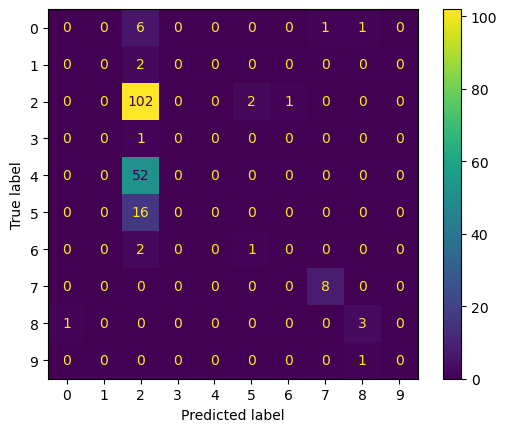

In [24]:
# Confusion Matrix
def generate_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    
generate_confusion_matrix(y_test=y_test, y_pred=y_pred)

In [25]:
# Evaluation metrics
def generate_evaluation_metrics(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    print(f'Accuracy is {accuracy}')
    print(f'F1 score is {f1}')
    print(f'Precision is {precision}')
    print(f'Recall is {recall}')

generate_evaluation_metrics(y_test=y_test, y_pred=y_pred)

Accuracy is 0.565
F1 score is 0.4254559166323873
Precision is 0.34341190914671577
Recall is 0.565


/opt/anaconda3/envs/parliament_new/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [41]:
# Directory to save figures
save_dir = "figures"
os.makedirs(save_dir, exist_ok=True)

In [42]:
# Random Forest optimized by GridSearchCV: Find importance of predictors
rf_feature_importance = list(random_forest_model.best_estimator_.feature_importances_)

# Match feature importances to their respective columns 
rf_features_dict = dict(zip(train_columns, rf_feature_importance))
rf_features_dict

{'X': 0.25692751865152413,
 'Y': 0.4415164414542834,
 'OPERATOR_NAME_M1': 0.11504336047907063,
 'OPERATOR_NAME_MyRepublic': 0.07312909002790506,
 'OPERATOR_NAME_Singtel': 0.11338358938721685}

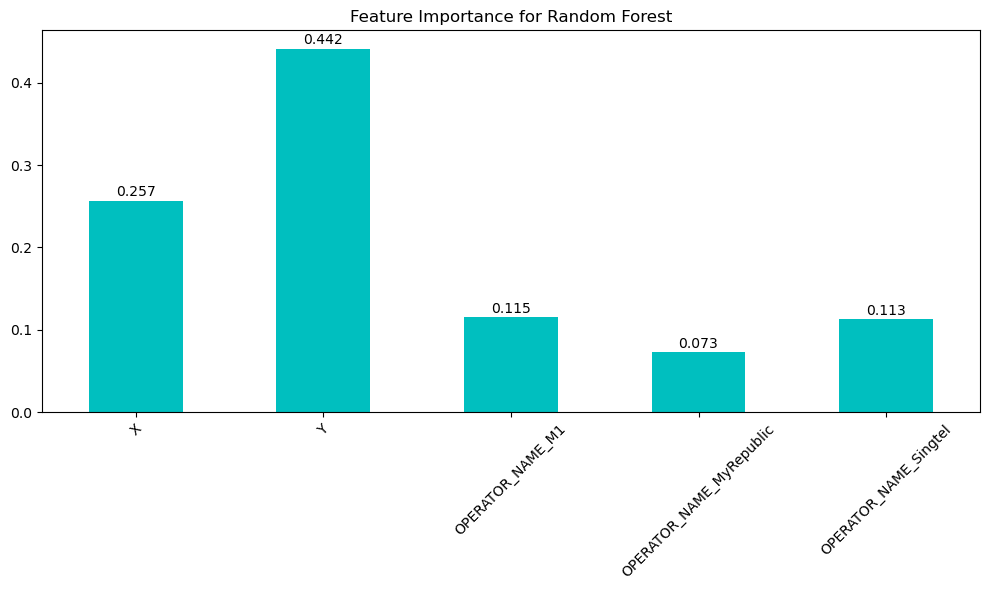

In [46]:
# Visualize feature importance for random forest
rf_features_df = pd.DataFrame(rf_features_dict, index=[0])

# Plotting with Matplotlib
fig, ax = plt.subplots(figsize=(10, 6))
bars = rf_features_df.T.plot(kind='bar', ax=ax, color='c', legend=False)
ax.set_title("Feature Importance for Random Forest")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if necessary

# Add annotations
for bar in bars.patches:
    ax.text(bar.get_x() + bar.get_width() / 2,  # x-coordinate
            bar.get_height() + 0.01,           # y-coordinate, offset by a small value above the bar
            f'{bar.get_height():.3f}',         # formatted text to display
            ha='center', va='center',          # alignment
            fontsize=10,                       # font size
            color='black',                     # text color
            rotation=0,                        # no rotation
            )
    
plt.tight_layout()

# Save the plot
plt.savefig(os.path.join(save_dir, "RF_Feature_Importance.png"))

plt.show()